# Data exploration

## Import moduels

In [1]:
#import moduels
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
#from sklearn.naive_bayes import GaussianNB
#from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier
#from xgboost import XGBClassifier
#xgb=XGBClassifier()
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import ExtraTreesClassifier
#from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
from xgboost import XGBClassifier
import pandas_profiling

import pandas as pd
from datetime import datetime
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, precision_score
#import xgboost as xgb

from sklearn.model_selection import StratifiedKFold
from imblearn.metrics import geometric_mean_score as geo
from imblearn.metrics import make_index_balanced_accuracy as iba
from sklearn.metrics import roc_curve, auc
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced

## Load data as dataframe and data overview

In [3]:
df = pd.read_csv('Data (2).csv')

In [3]:
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


In [5]:
#no missing values
df.isnull().sum()

date       0
device     0
failure    0
metric1    0
metric2    0
metric3    0
metric4    0
metric5    0
metric6    0
metric7    0
metric8    0
metric9    0
dtype: int64

In [6]:
#imbalanced classification problem
df.failure.value_counts()

0    124388
1       106
Name: failure, dtype: int64

In [7]:
#no duplicated observations
df.duplicated().sum()


1

In [8]:
df.nunique()

date          304
device       1169
failure         2
metric1    123877
metric2       558
metric3        47
metric4       115
metric5        60
metric6     44838
metric7        28
metric8        28
metric9        65
dtype: int64

## Summary
* This dataset is clean, no missing values. All attributes are integer data type.
* It is imbalanced data set, as the failuer class is about 0.1% of unfailure class.Here oversampling approach is used to deal with imbalanced dataset.
* Some attributes have limited number of distictive values, very sparse, indicating that they are likely to be categorical variable, such as attibute 3, 5,7,9.
* Attribute7 and 8 seems like exactly same to each other, we can drop one of them.
* Attribute 2,3,4,7,9 are highly skewed.
* Attributes differ in their magnitudes. Scaling or centering is requried.

# Data Engineering

## 'Date' exploration

### Create features bsed on date

In [9]:
# create three more features based on date.
df.date = pd.to_datetime(df.date)

df['activedays']=df.date-df.date[0]

df['month']=df['date'].dt.month
df['week_day']=df.date.dt.weekday
df['week_day'].replace(0,7,inplace=True)
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,week_day
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7,0 days,1,3
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0,0 days,1,3
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0,0 days,1,3
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0,0 days,1,3
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3,0 days,1,3


In [10]:
df.groupby('month').agg({'device':lambda x: x.nunique()})

,device
month,
1,1164
2,726
3,685
4,491
5,424
6,353
7,346
8,334
9,184


### Data visualization in Date

<AxesSubplot:xlabel='month'>

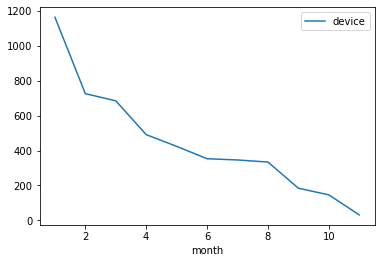

In [11]:
df.groupby('month').agg({'device':lambda x: x.nunique()}).plot()

This figure shows that as time move on, the number of devices are getting less and less.

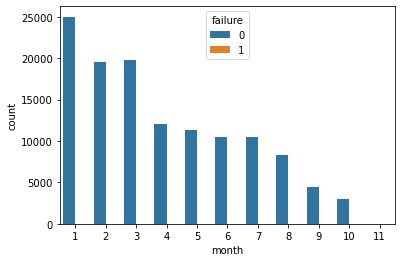

In [12]:
ax = sns.countplot(x="month", hue="failure", data=df)

This figure shows most of the devices failed in the first month.

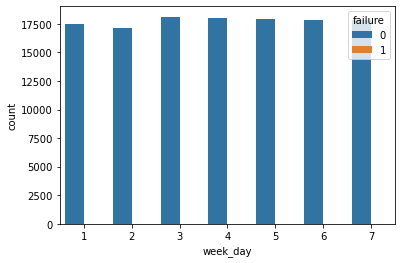

In [13]:
ax = sns.countplot(x='week_day',hue='failure',data=df)

This figure shows that there is no device fails on Friday and Saturday. Maybe they don't work on the two days.

<AxesSubplot:xlabel='activedays'>

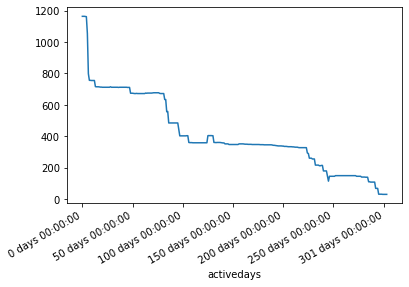

In [14]:
df.groupby('activedays')['device'].count().plot()

 One can see that the number of devices decreases as time goes by. And there is a big jump in the middle of activedays. Those may be some devices got put back in after they failed and fixed well. We will investigate the detail later.

In [16]:
max(df.date), min(df.date)

(Timestamp('2015-11-02 00:00:00'), Timestamp('2015-01-01 00:00:00'))

All of these data are collected between 11/02/2015 and 01/01/2015

### Devices come back to use

In [17]:
df_date = df.groupby('device').agg({'date':max})

df_date.date.to_dict()

df_failure = df.loc[df.failure==1,['device','date']]


df_good = df.loc[df.failure==0,['device','date']]

df_date.shape,df_failure.shape

df['max_date']=df.device.map(df_date.date.to_dict())

df.head()

#dfa = df[~df.device.isin(df_failure.device)]

dff=df[(df.failure==1)&(df.date!=df.max_date)]
dff

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,week_day,max_date
77958,2015-05-05,S1F136J0,1,131519808,0,0,25,16,343464,8,8,0,124 days,5,1,2015-05-06
79590,2015-05-09,W1F0KCP2,1,176861128,10392,0,121,6,310699,0,0,0,128 days,5,5,2015-05-11
79601,2015-05-09,W1F0M35B,1,141805096,0,0,1,7,267203,0,0,0,128 days,5,5,2015-05-11
101999,2015-07-12,S1F0GPFZ,1,236544080,0,0,0,9,264594,0,0,0,192 days,7,6,2015-07-24
104223,2015-07-18,W1F11ZG9,1,32671632,368,9,486,3,344433,0,0,1,198 days,7,5,2015-08-17


Max date means the last day the device got checked. If the max day is ahead of failure date, it means this device returned to use after failed because got fixed.

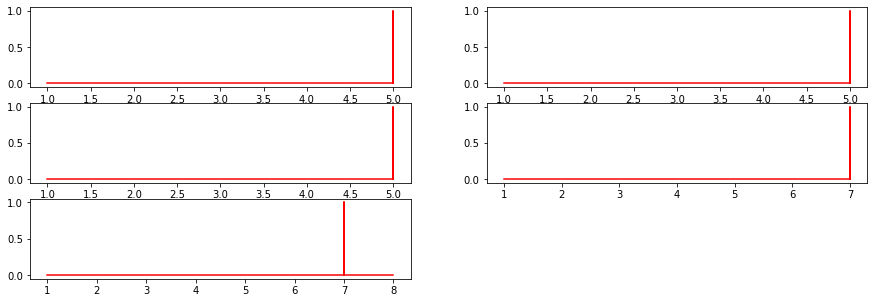

In [18]:
fig = plt.figure(figsize=(15,5))
fig.add_subplot(3, 2, 1) 
plt.plot(df.loc[df['device']=='S1F136J0',['failure','month']]['month'],df.loc[df['device']=='S1F136J0',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 2) 
plt.plot(df.loc[df['device']=='W1F0KCP2',['failure','month']]['month'],df.loc[df['device']=='W1F0KCP2',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 3)
plt.plot(df.loc[df['device']=='W1F0M35B',['failure','month']]['month'],df.loc[df['device']=='W1F0M35B',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 4)
plt.plot(df.loc[df['device']=='S1F0GPFZ',['failure','month']]['month'],df.loc[df['device']=='S1F0GPFZ',\
         ['failure','month']]['failure'],\
         color = 'red')
fig.add_subplot(3, 2, 5)
plt.plot(df.loc[df['device']=='W1F11ZG9',['failure','month']]['month'],df.loc[df['device']=='W1F11ZG9',\
         ['failure','month']]['failure'],\
         color = 'red')

plt.show()

In [19]:
df[df.device == 'S1F136J0']

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,week_day,max_date
500,2015-01-01,S1F136J0,0,229928576,0,0,25,16,312312,0,0,0,0 days,1,3,2015-05-06
1663,2015-01-02,S1F136J0,0,6051808,0,0,25,16,313710,0,0,0,1 days,1,4,2015-05-06
2826,2015-01-03,S1F136J0,0,29281832,0,0,25,16,315035,0,0,0,2 days,1,5,2015-05-06
3989,2015-01-04,S1F136J0,0,54942936,0,0,25,16,316364,0,0,0,3 days,1,6,2015-05-06
5150,2015-01-05,S1F136J0,0,73810232,0,0,25,16,317707,0,0,0,4 days,1,7,2015-05-06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76881,2015-05-02,S1F136J0,0,55535800,0,0,25,16,340161,8,8,0,121 days,5,5,2015-05-06
77240,2015-05-03,S1F136J0,0,72745992,0,0,25,16,341416,8,8,0,122 days,5,6,2015-05-06
77599,2015-05-04,S1F136J0,0,81808304,0,0,25,16,342707,8,8,0,123 days,5,7,2015-05-06
77958,2015-05-05,S1F136J0,1,131519808,0,0,25,16,343464,8,8,0,124 days,5,1,2015-05-06


## Reduce data set with unique device id

In [24]:
df.metric1.nunique()

123877

In [25]:
# Here I just keep the last record, as it comes with the most usefull infomation.
df1 = df.groupby('device').agg({'date':max})

In [26]:
df1.shape

(1169, 1)

In [27]:
df1=df1.reset_index()

df=df.reset_index(drop=True) 

df2= pd.merge(df1,df,how='left',on=['device','date'])

df2.shape


(1169, 16)

In [28]:
df2.tail()

,device,date,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,week_day,max_date
1164,Z1F1VMZB,2015-10-19,0,96949360,0,0,0,5,263507,0,0,0,291 days,10,7,2015-10-19
1165,Z1F1VQFY,2015-06-30,1,178051496,0,0,0,7,265316,0,0,0,180 days,6,1,2015-06-30
1166,Z1F26YZB,2015-03-25,0,229065488,0,1,0,1,292052,0,0,0,83 days,3,2,2015-03-25
1167,Z1F282ZV,2015-03-25,0,72717600,0,1,0,1,192919,0,0,0,83 days,3,2,2015-03-25
1168,Z1F2PBHX,2015-04-06,0,130522432,0,0,0,5,164020,0,0,0,95 days,4,7,2015-04-06


### Create  feature called  'failure_before' 

If we just take the last record for the devices, we may lose information from those come back after failed ones

In [29]:
df2['failure_before']=0

In [30]:
df2.loc[df2.device == 'S1F136J0','failure_before'] = 1
df2.loc[df2.device == 'W1F0KCP2','failure_before'] = 1
df2.loc[df2.device == 'W1F0M35B','failure_before'] = 1
df2.loc[df2.device == 'S1F0GPFZ','failure_before'] = 1
df2.loc[df2.device == 'W1F11ZG9','failure_before'] = 1

## Redefine device Id value

In [31]:
df2.device

0       S1F01085
1       S1F013BB
2       S1F0166B
3       S1F01E6Y
4       S1F01JE0
          ...   
1164    Z1F1VMZB
1165    Z1F1VQFY
1166    Z1F26YZB
1167    Z1F282ZV
1168    Z1F2PBHX
Name: device, Length: 1169, dtype: object

In [32]:
Id = df2.device.values.tolist()

In [33]:
#change device id values to the first four characters
Id1 = [] 
for i in Id:
    i = i[:4]
    Id1.append(i)

df2.device=Id1

df2.device.value_counts()

S1F0    391
W1F0    282
Z1F0    149
S1F1    139
W1F1    138
Z1F1     67
Z1F2      3
Name: device, dtype: int64

In [34]:
dev=pd.crosstab(df2['device'],df2['failure']) 

<AxesSubplot:xlabel='device'>

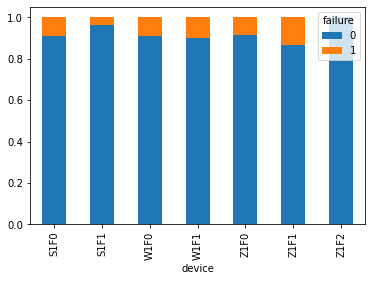

In [35]:
dev.div(dev.sum(1).astype(float), axis=0).plot(kind="bar", stacked=True) 

Devices ID begins with ZIF0 fails the most, then W1F1 second

## Data transformation

### Redefing data types

In [37]:

#redefine data type for some of the numerical features
cat_ftrs = ['metric3','metric4', 'metric5', 'metric7', 'metric9'] 
for col in cat_ftrs:
    df2[col]=df2[col].astype('object')

In [38]:
# change activedays datatype to numerical
def str_to_num(str):
    return str.split(' ')[0]

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype          
---  ------          --------------  -----          
 0   device          1169 non-null   object         
 1   date            1169 non-null   datetime64[ns] 
 2   failure         1169 non-null   int64          
 3   metric1         1169 non-null   int64          
 4   metric2         1169 non-null   int64          
 5   metric3         1169 non-null   object         
 6   metric4         1169 non-null   object         
 7   metric5         1169 non-null   object         
 8   metric6         1169 non-null   int64          
 9   metric7         1169 non-null   object         
 10  metric8         1169 non-null   int64          
 11  metric9         1169 non-null   object         
 12  activedays      1169 non-null   timedelta64[ns]
 13  month           1169 non-null   int64          
 14  week_day        1169 non-null   int64   

In [39]:
df2.activedays = df2.activedays.astype('str')

df2.activedays=df2.activedays.apply(str_to_num)
df2.activedays = df2.activedays.astype('int')
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   device          1169 non-null   object        
 1   date            1169 non-null   datetime64[ns]
 2   failure         1169 non-null   int64         
 3   metric1         1169 non-null   int64         
 4   metric2         1169 non-null   int64         
 5   metric3         1169 non-null   object        
 6   metric4         1169 non-null   object        
 7   metric5         1169 non-null   object        
 8   metric6         1169 non-null   int64         
 9   metric7         1169 non-null   object        
 10  metric8         1169 non-null   int64         
 11  metric9         1169 non-null   object        
 12  activedays      1169 non-null   int32         
 13  month           1169 non-null   int64         
 14  week_day        1169 non-null   int64         
 15  max_

In [40]:
for col in ['month','week_day']:
    df2[col]=df2[col].astype('object')

### Data standarlization

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log-Transformed Distribution')

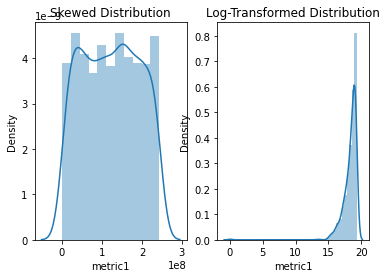

In [43]:
#numerical features normalization
f, axarr = plt.subplots(1,2) 
sns.distplot(df2['metric1'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['metric1']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Log-Transformed Distribution')

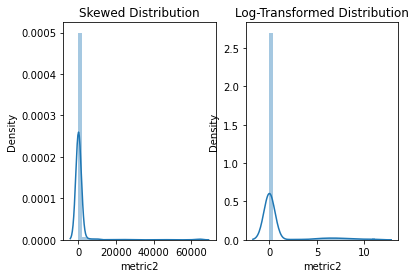

In [44]:
f, axarr = plt.subplots(1,2) 

sns.distplot(df2['metric2'],ax=axarr[0]) 
axarr[0].set_title('Skewed Distribution') 
sns.distplot(np.log(1+df2['metric2']),ax=axarr[1]) 
axarr[1].set_title('Log-Transformed Distribution')

It seems the data get more skewed after log, so I'd rather not take log on them.

In [45]:
#numerical features standardization
num_ftrs =['metric1','metric2','metric6'] 
df2[num_ftrs]=scaler.fit_transform(df2[num_ftrs])

df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   device          1169 non-null   object        
 1   date            1169 non-null   datetime64[ns]
 2   failure         1169 non-null   int64         
 3   metric1         1169 non-null   float64       
 4   metric2         1169 non-null   float64       
 5   metric3         1169 non-null   object        
 6   metric4         1169 non-null   object        
 7   metric5         1169 non-null   object        
 8   metric6         1169 non-null   float64       
 9   metric7         1169 non-null   object        
 10  metric8         1169 non-null   int64         
 11  metric9         1169 non-null   object        
 12  activedays      1169 non-null   int32         
 13  month           1169 non-null   object        
 14  week_day        1169 non-null   object        
 15  max_

## Drop unimportant and redundant features 

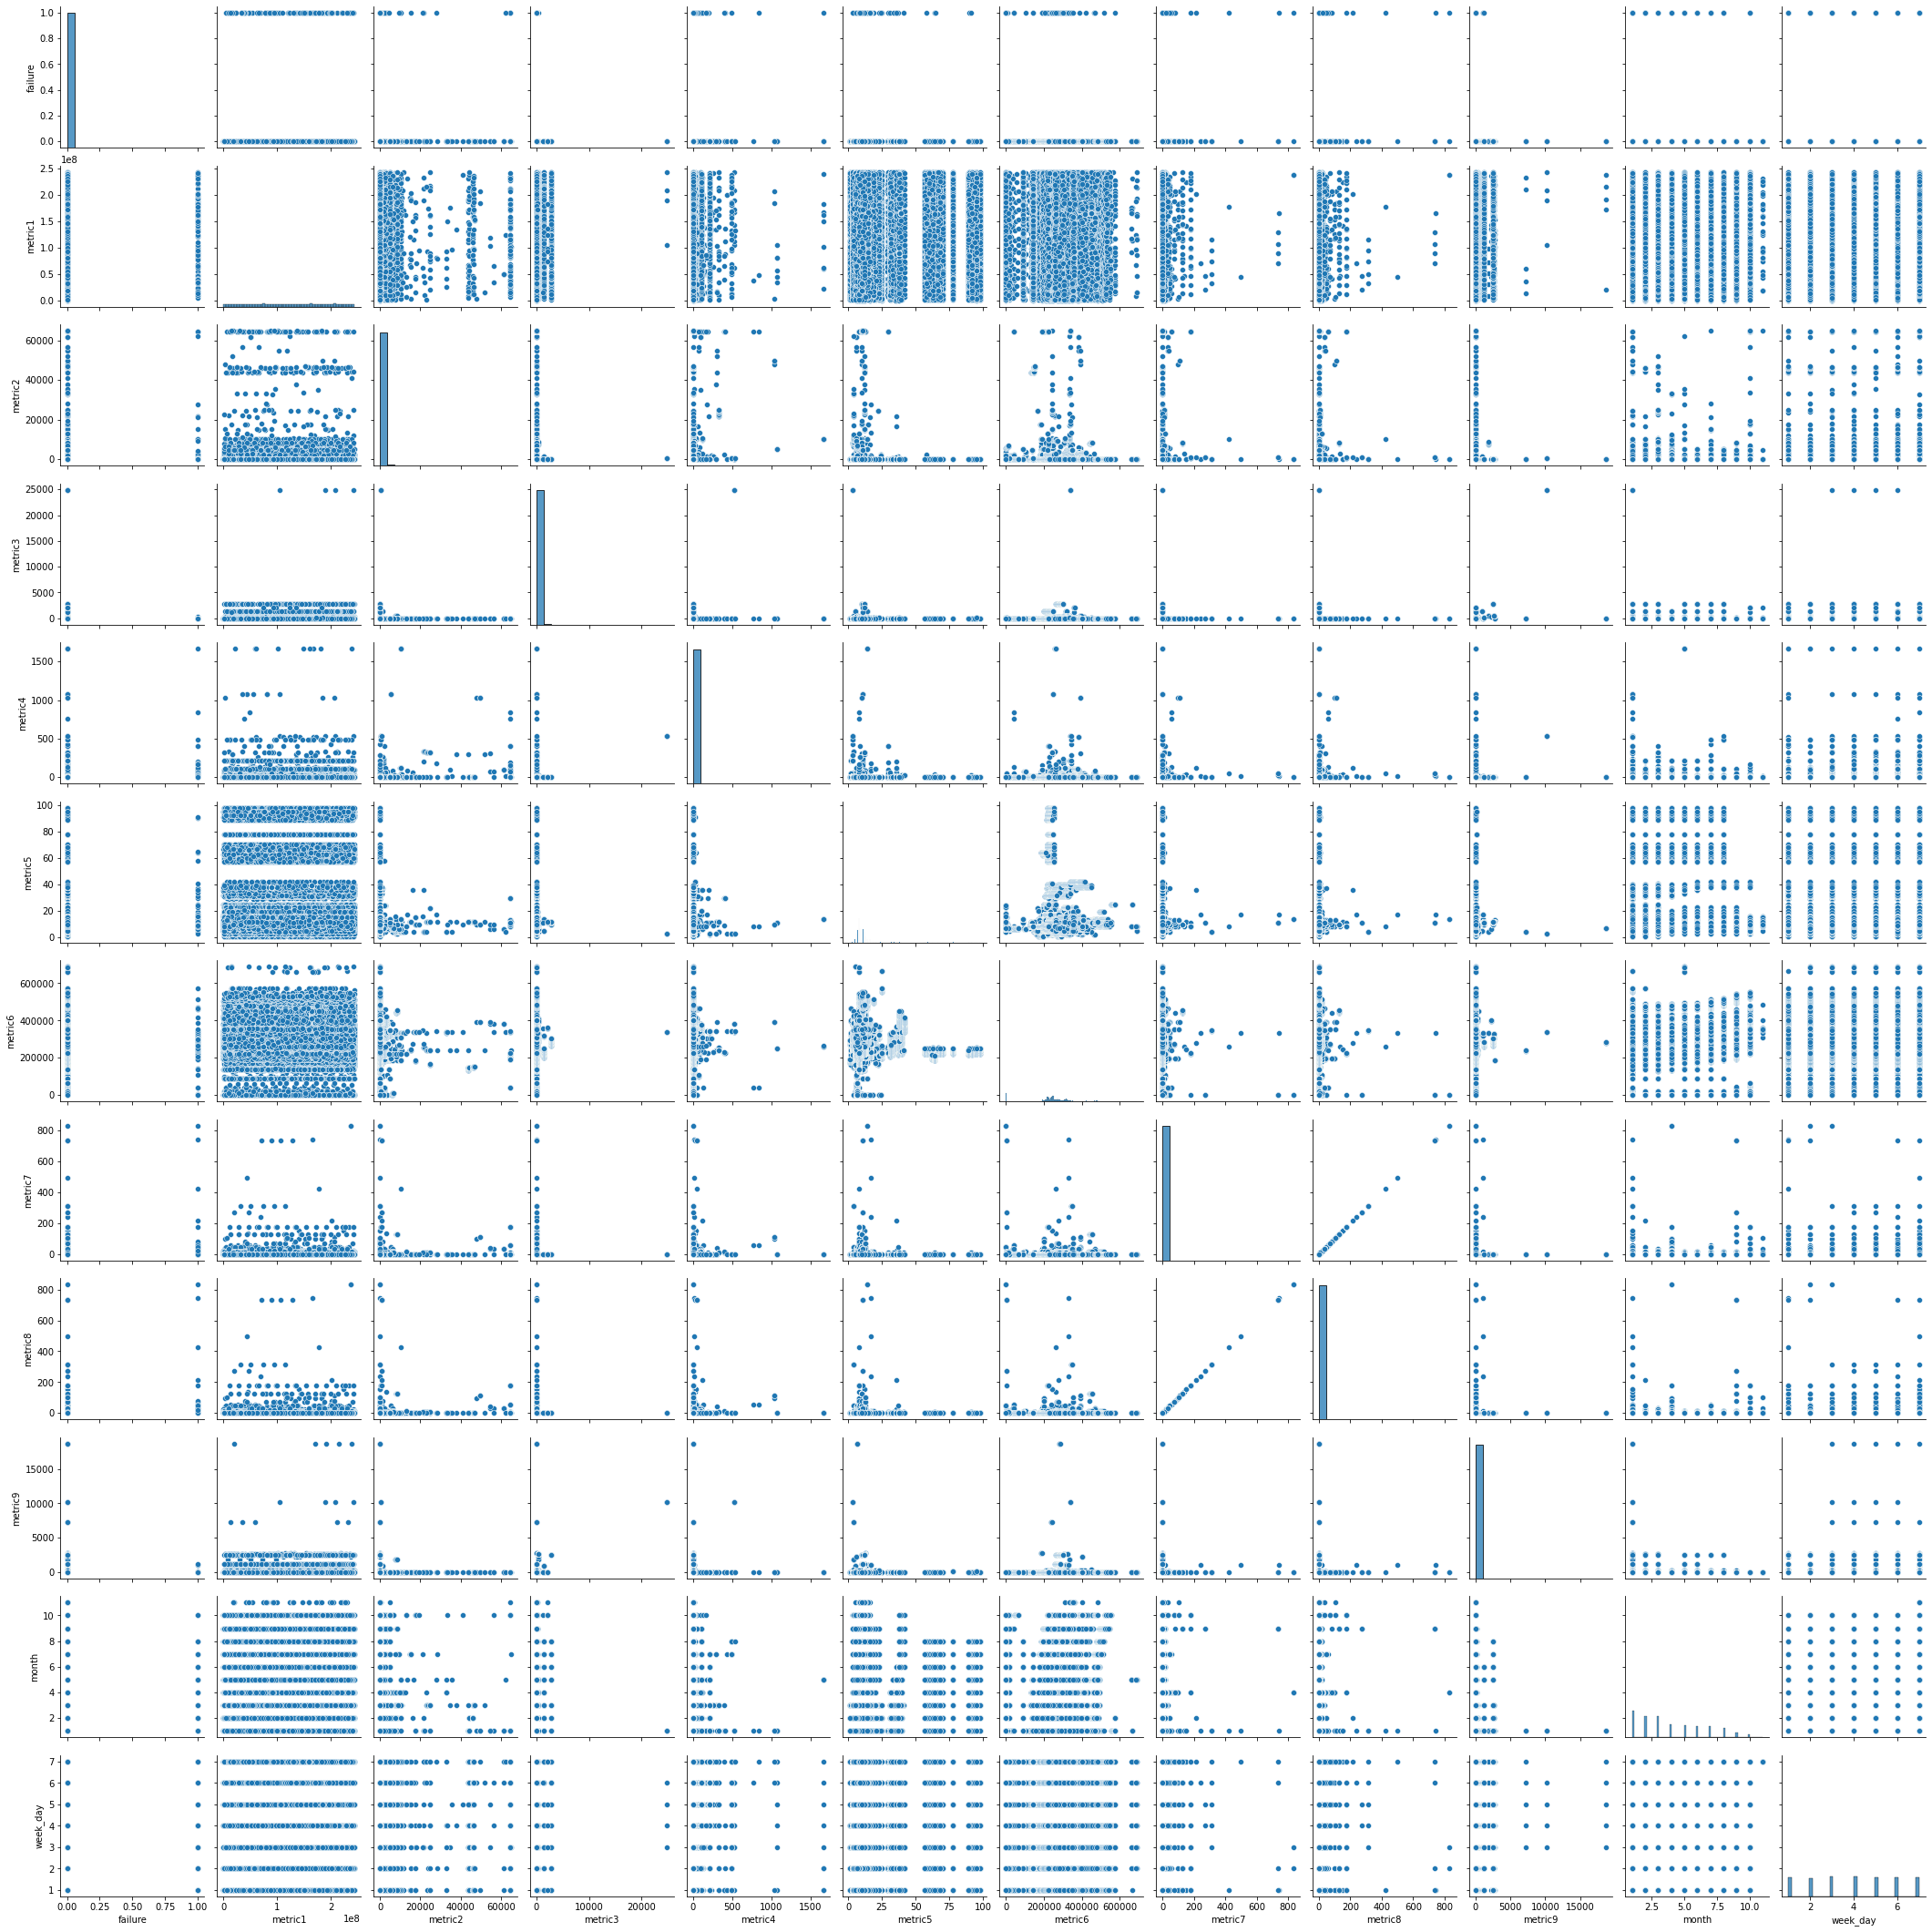

In [46]:
sns.pairplot(df)

It is obvious that attribute7 and attribut8 is highly linear related or equal to each other

In [48]:
(df['metric7']==df['metric8']).value_counts()

True    124494
dtype: int64

In [49]:
# then I drop attribute 8, as it is duplicated.
df.drop('metric8',axis=1,inplace=True)

In [50]:
df.head()

,date,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric9,activedays,month,week_day,max_date
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,7,0 days,1,3,2015-01-06
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0 days,1,3,2015-01-06
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0 days,1,3,2015-02-17
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0 days,1,3,2015-01-06
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,3,0 days,1,3,2015-08-24


In [51]:
df2.drop(['date','max_date'],axis=1,inplace=True)

In [52]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1169 entries, 0 to 1168
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   device          1169 non-null   object 
 1   failure         1169 non-null   int64  
 2   metric1         1169 non-null   float64
 3   metric2         1169 non-null   float64
 4   metric3         1169 non-null   object 
 5   metric4         1169 non-null   object 
 6   metric5         1169 non-null   object 
 7   metric6         1169 non-null   float64
 8   metric7         1169 non-null   object 
 9   metric8         1169 non-null   int64  
 10  metric9         1169 non-null   object 
 11  activedays      1169 non-null   int32  
 12  month           1169 non-null   object 
 13  week_day        1169 non-null   object 
 14  failure_before  1169 non-null   int64  
dtypes: float64(3), int32(1), int64(3), object(8)
memory usage: 141.6+ KB


## get dummies on categorical feature

In [53]:
df2.head()

,device,failure,metric1,metric2,metric3,metric4,metric5,metric6,metric7,metric8,metric9,activedays,month,week_day,failure_before
0,S1F0,0,0.094795,-0.136309,0,52,6,1.333502,0,0,7,5,1,1,0
1,S1F0,0,-0.092146,-0.145660,0,0,5,4.008798,0,0,0,130,5,7,0
2,S1F0,0,-1.630184,-0.145660,3,0,6,1.289341,0,0,0,5,1,1,0
3,S1F0,0,0.357937,-0.145660,0,0,12,-0.100105,0,0,0,47,2,1,0
4,S1F0,0,0.898989,-0.145660,0,0,6,1.359772,0,0,0,5,1,1,0


In [54]:
df2 = pd.get_dummies(df2,drop_first=True)

In [55]:
df2.shape

(1169, 278)

In [56]:
df2.failure.value_counts()

0    1068
1     101
Name: failure, dtype: int64

# Feature Selection

## Define dependent and independent values

In [57]:
X = df2.drop('failure',axis=1)
Y = df2.failure

## Feature Selection

<AxesSubplot:ylabel='feature'>

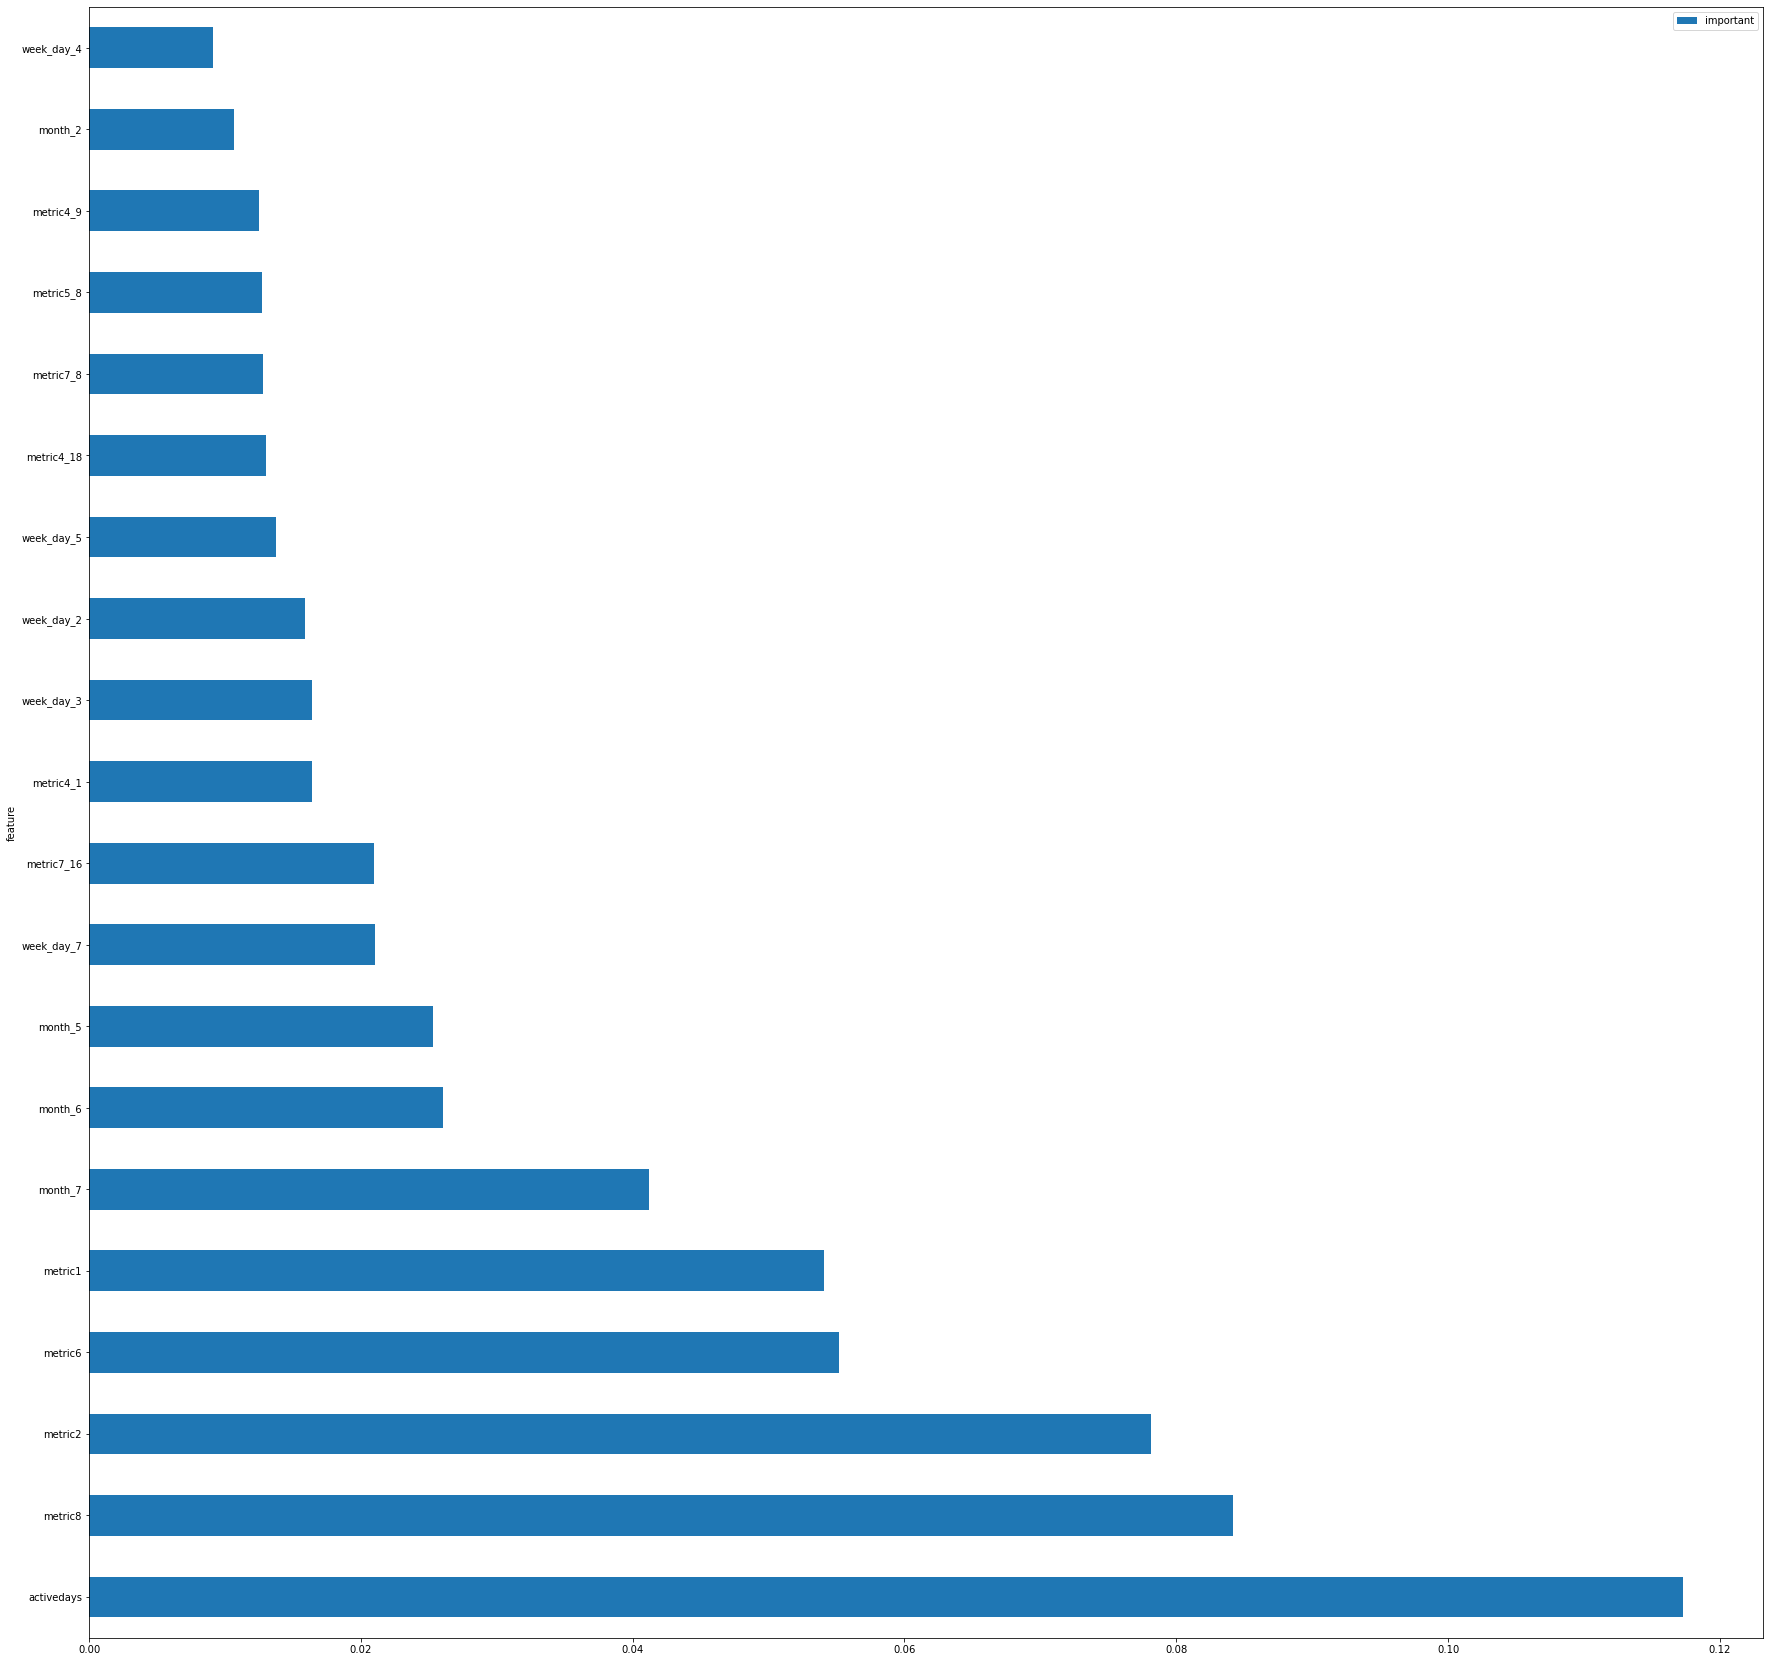

In [58]:
clf = RandomForestClassifier(n_estimators=50, max_features='auto')
clf= clf.fit(X,Y)

features = pd.DataFrame()
features['feature']= X.columns
features['important']=clf.feature_importances_
features.sort_values(by=['important'], ascending=False,inplace=True)
features.set_index('feature', inplace=True)
features.iloc[:20,:].plot(kind='barh', figsize=(30,30))

In [59]:
model = SelectFromModel(clf,prefit=True)
x_reduced = model.transform(X)
print (x_reduced.shape)


(1169, 53)


C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


In [60]:
type(x_reduced)

numpy.ndarray

In [61]:
x_reduced=pd.DataFrame(x_reduced)

In [62]:
x_reduced.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.094795,-0.136309,1.333502,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.092146,-0.145660,4.008798,0.0,130.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,-1.630184,-0.145660,1.289341,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.357937,-0.145660,-0.100105,0.0,47.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.898989,-0.145660,1.359772,0.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [63]:
x_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1169 entries, 0 to 1168
Data columns (total 53 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       1169 non-null   float64
 1   1       1169 non-null   float64
 2   2       1169 non-null   float64
 3   3       1169 non-null   float64
 4   4       1169 non-null   float64
 5   5       1169 non-null   float64
 6   6       1169 non-null   float64
 7   7       1169 non-null   float64
 8   8       1169 non-null   float64
 9   9       1169 non-null   float64
 10  10      1169 non-null   float64
 11  11      1169 non-null   float64
 12  12      1169 non-null   float64
 13  13      1169 non-null   float64
 14  14      1169 non-null   float64
 15  15      1169 non-null   float64
 16  16      1169 non-null   float64
 17  17      1169 non-null   float64
 18  18      1169 non-null   float64
 19  19      1169 non-null   float64
 20  20      1169 non-null   float64
 21  21      1169 non-null   float64
 22  

# Resample data-test
when encounter with imbalanced dataset, we always re-sample the data in order to mitigate the effect caused by class imbalance. The two most common techniques are over-sampling and under-sampling. Here I used under-sampling as the dataset is little big.

In [64]:
# import model for imbalanced data set
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import geometric_mean_score, make_index_balanced_accuracy, classification_report_imbalanced
from sklearn.metrics import confusion_matrix

In [66]:
# tested on RandomForestClassifier
X_train, X_test, y_train, y_test = train_test_split(x_reduced, Y, train_size=0.8, \
                                                    random_state=42)


rus = RandomOverSampler(random_state=42)
#With my training data craeated, I'll upsample the failed devices using the RandomOverSampler. This method object to over-sample the minority class(es) by picking samples at random with replacement.

X_res, y_res = rus.fit_resample(X_train, y_train)
X_res.shape

X_res = pd.DataFrame(X_res)
#After upsampling, I'll build a random forest model to classify the failed devices.

rf = RandomForestClassifier(n_estimators=5000, random_state=21)

a = rf.fit(X_res,y_res)



rf_test_pred = rf.predict(X_test)
rf_test_cm = confusion_matrix(y_test, rf_test_pred)
rf_test_cm

accuracy_score(y_test, rf_test_pred)

print(classification_report_imbalanced(y_test,rf_test_pred))

                   pre       rec       spe        f1       geo       iba       sup

          0       0.97      0.98      0.56      0.97      0.74      0.58       218
          1       0.69      0.56      0.98      0.62      0.74      0.53        16

avg / total       0.95      0.95      0.59      0.95      0.74      0.57       234



* pre is precision, which is a measure of result relevancy;
* rec is recall, which is the same as sensitivity. Recall is a measure of how many truly relevant results are returned;
* spe is specificity;
* f1 is the harmonic average of the precision and recall;
* geo(Matthews correlation coefficient) is the geometric mean of specificity and sensitivity;
* iba is the index of imbalanced accuracy

# Model Training

## Oversample before cross validate

In [67]:
log=LogisticRegression()
k=KNeighborsClassifier()
gbc =GradientBoostingClassifier()
rgr = RandomForestRegressor(n_estimators=100)
svc = SVC()
rfc = RandomForestClassifier(n_estimators=10)
xg_reg = XGBClassifier(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
clf = MLPClassifier(solver='lbfgs', alpha=1e-5,\
                    hidden_layer_sizes=(5, 2), random_state=1)
algorithms=[k,log,gbc,rgr,svc,rfc,xg_reg,clf]
names=['KNeighborsClassifier','Logistic','GradientBoost','RandomForest','SVC','RandomForestCl','xgboost','neunet']

In [68]:
iba = make_index_balanced_accuracy(alpha=0.1, squared=True)(geo)

In [73]:
def cross_vali_fit_pred_1(X_res, y_res, algorithms = algorithms, names = names):
    # fit the data
    #x_train_reduced, x_test_reduced, y_train, y_test = train_test_split(x_reduced,Y,test_size=0.1, random_state=13)
    X_res = X_res.to_numpy()
    Geo_score = []
    Iba_score = []
    Accuracy = []
    F1 = []
    Recall = []
    Prec = []
    for i in range(len(algorithms)):
        j=1
        kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
        geo_score = []
        iba_score = []
        accuracy = []
        f1 = []
        recall = []
        prec = []
        for train_index,test_index in kf.split(X_res,y_res):
            xtr,xvd=X_res[train_index],X_res[test_index]
            ytr,yvd=y_res[train_index],y_res[test_index]
            algorithms[i] = algorithms[i].fit(xtr,ytr)
            y_pred_test = algorithms[i].predict(xvd).round()
            accuracy.append(accuracy_score(yvd, y_pred_test))
            geo_score.append(geo(yvd, y_pred_test))
            iba_score.append(iba(yvd, y_pred_test))
            f1.append(f1_score(yvd, y_pred_test,average='macro'))
            recall.append(recall_score(yvd, y_pred_test,average='macro'))
            prec.append(precision_score(yvd, y_pred_test))
            j +=1
        mean_ac = np.mean(accuracy)
        mean_geo = np.mean(geo_score)
        mean_f1 = np.mean(f1)
        mean_iba = np.mean(iba_score)
        mean_recall = np.mean(recall)
        mean_prec = np.mean(prec)
        F1.append(mean_f1)
        Geo_score.append(mean_geo)
        Iba_score.append(mean_iba)
        Accuracy.append(mean_ac)
        Recall.append(mean_recall)
        Prec.append(mean_prec)
        #cm=confusion_matrix(y_test,y_test_pred)
        #print(cm)
    metrics = pd.DataFrame(columns = ['Accuracy','geo_score','iba_score','f1','recall','prec'],index=names)
    metrics['Accuracy']=Accuracy
    metrics['geo_score']=Geo_score
    metrics['iba_score']=Iba_score
    metrics['f1']=F1
    metrics['recall']=Recall
    metrics['prec'] =Prec
    return metrics.sort_values('geo_score',ascending=False)

In [74]:
cross_vali_fit_pred_1(X_res, y_res, algorithms = algorithms, names = names)

C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\hp\AppData\Roaming\Python\Python38\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html

[05:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[05:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.
[05:38:01] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/objective/regression_obj.cu:188: reg:linear is now deprecated in favor of reg:squarederror.


,Accuracy,geo_score,iba_score,f1,recall,prec
RandomForestCl,0.990000,0.989945,0.980000,0.989999,0.990000,0.980426
KNeighborsClassifier,0.987059,0.986966,0.974118,0.987056,0.987059,0.974830
RandomForest,0.985882,0.985775,0.971765,0.985879,0.985882,0.972583
GradientBoost,0.981765,0.981713,0.963772,0.981763,0.981765,0.973455
xgboost,0.931176,0.930894,0.866685,0.931139,0.931176,0.914377
Logistic,0.881176,0.880598,0.775841,0.881046,0.881176,0.892554
SVC,0.702941,0.701931,0.493467,0.702530,0.702941,0.692433
neunet,0.562941,0.367092,0.137924,0.466694,0.562941,0.905236
